In [66]:
from tensorflow import Tensor
from keras.layers import Input, Dense, Conv2D, ReLU, Reshape, UpSampling2D, Add
from keras.models import Model
import root_numpy
import numpy as np
import sklearn.preprocessing
import skimage.measure
import matplotlib.pyplot as plt

Residual block code, including encoding and decoding.

In [40]:
def residual_block_enc(x, filter_number, kernel_size, strides):
    y = Conv2D(filter_number, kernel_size, padding="valid", strides=strides)(x)
    y = ReLU()(y)
    y = Conv2D(filter_number, kernel_size, padding="same")(y)
    
    x = Conv2D(filter_number, kernel_size, padding="valid", strides=strides)(x)
    
    out = Add()([x, y])
    return out

def residual_block_dec(x, filter_number, kernel_size, upsampling_kernel):
    y = UpSampling2D(upsampling_kernel, interpolation="bilinear")(x)
    y = Conv2D(filter_number, kernel_size, padding="same")(y)
    y = ReLU()(y)
    y = Conv2D(filter_number, kernel_size, padding="same")(y)
    
    x = UpSampling2D(upsampling_kernel, interpolation="bilinear")(x)
    x = Conv2D(filter_number, kernel_size, padding="same")(x)
    
    out = Add()([x, y])
    return out

Base model. For the first trial I wanted to make a small architecture, similar to the old autoencoder.

In [44]:
input_shape = (40, 28, 1)
def base_model():
    input_layer = Input(shape=input_shape)
    resnet_layer = residual_block_enc(input_layer, 60, (4, 4), 4)
    resnet_layer = residual_block_enc(resnet_layer, 60, (5, 1), (5, 1))
    
    resnet_layer = residual_block_dec(resnet_layer, 60, (3, 3), (5, 1))
    resnet_layer = residual_block_dec(resnet_layer, 1, (4, 4), (4, 4))
    
    resnet_model = Model(inputs = [input_layer], outputs = [resnet_layer])
    resnet_model.compile(loss = "mse", optimizer="adadelta")
    return resnet_model

In [45]:
model1 = base_model()

In [46]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 40, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 10, 7, 60)    1020        input_11[0][0]                   
__________________________________________________________________________________________________
re_lu_8 (ReLU)                  (None, 10, 7, 60)    0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 10, 7, 60)    1020        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_33 

Small set of training data. I tried training with Minsky, but it seems that there is an out-of-memory issue on all Minsky machines. (╯°□°）╯︵ ┻━┻

In [61]:
Bchain_zphi1 = root_numpy.root2array("/eos/user/v/vwachira/Pixel2D/ZeroBias_2017B_DataFrame_2D_1.root", "lumisections", "hist_zphi1", "isGoodLumi==1")
Bchain_zphi1 = np.reshape(Bchain_zphi1, (-1, 202, 302))
Bchain_zphi1_2D = np.reshape(Bchain_zphi1, (-1, 202, 302))[:, 1:201, 80:220]
Bchain_zphi1_2D = Bchain_zphi1_2D[np.sum(np.sum(Bchain_zphi1_2D != 0, 1), 1) != 1]
Bchain_zphi1_2D = Bchain_zphi1_2D[np.sum(np.reshape(Bchain_zphi1_2D != 0, (-1, 200*140)), axis=1) > 20000]
Bchain_zphi1_2D = np.reshape(Bchain_zphi1_2D, (-1, 200*140))
Bchain_zphi1_2D = sklearn.preprocessing.normalize(Bchain_zphi1_2D, norm="max")
Bchain_zphi1_2D = np.reshape(Bchain_zphi1_2D, (-1, 200, 140, 1))
Bchain_zphi1_2D = skimage.measure.block_reduce(Bchain_zphi1_2D, block_size=(1, 5, 5, 1), func=np.mean)

In [62]:
Bchain_zphi1_2D.shape

(531, 40, 28, 1)

Training on SWAN is considerably much slower.

In [63]:
model1.fit(Bchain_zphi1_2D, Bchain_zphi1_2D, epochs=100, verbose=True)

W0430 12:26:50.857150 139909261457216 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0430 12:26:50.867201 139909261457216 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/100
531/531 [==============================] - 8s 15ms/step - loss: 0.0336
Epoch 2/100
531/531 [==============================] - 7s 12ms/step - loss: 0.0043
Epoch 3/100
531/531 [==============================] - 7s 13ms/step - loss: 0.0054
Epoch 4/100
531/531 [==============================] - 7s 13ms/step - loss: 0.0042
Epoch 5/100
531/531 [==============================] - 7s 13ms/step - loss: 0.0050
Epoch 6/100
531/531 [==============================] - 7s 13ms/step - loss: 0.0047
Epoch 7/100
531/531 [==============================] - 7s 13ms/step - loss: 0.0050
Epoch 8/100
531/531 [==============================] - 7s 12ms/step - loss: 0.0048
Epoch 9/100
531/531 [==============================] - 7s 13ms/step - loss: 0.0047
Epoch 10/100
531/531 [==============================] - 7s 12ms/step - loss: 0.0046
Epoch 11/100
531/531 [==============================] - 7s 12ms/step - loss: 0.0046
Epoch 12/100
531/531 [==============================] - 7s 12ms/step - loss: 0.0047
E

2021-04-30 12:26:51.502368: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-04-30 12:26:51.524087: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400025000 Hz
2021-04-30 12:26:51.525700: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9a5ed10 executing computations on platform Host. Devices:
2021-04-30 12:26:51.525728: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-04-30 12:26:52.062533: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via T

An example of a truth histogram and predicted histogram from ResNet.

Text(0.5, 1.0, 'Predicted histogram')

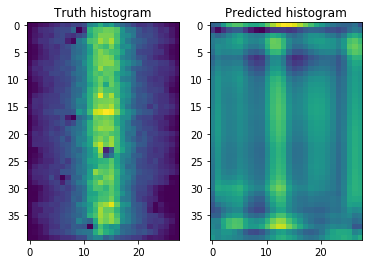

In [78]:
plt.subplot(1, 2, 1)
plt.imshow(np.reshape(Bchain_zphi1_2D[10], (40, 28)))
plt.title("Truth histogram")
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(model1.predict(np.reshape(Bchain_zphi1_2D[10], (1, 40, 28, 1))), (40, 28)))
plt.title("Predicted histogram")